In [1]:
import mysql.connector 
import config_aws
import requests
# import time  # This is just to be able to make multiple calls to the API in spaced out time intervals
# import string # For the remove_special_chars function
import pandas as pd
from sodapy import Socrata
import sqlalchemy as db
import pandas as pd
# from helpers import (query, query_list)

In [2]:
#instantiate the connection and table

engine = db.create_engine(f'mysql+mysqlconnector://{config_aws.user}:{config_aws.pw}@{config_aws.host}/building_permits')

connection = engine.connect()
metadata=db.MetaData()

In [3]:
def query(q):
    try:
        return pd.read_sql_query(q, engine)
    # Pass when no data is returned    
    except ResourceClosedError:
        pass

def query_list(col, table, distinct = True):
    elts = ['SELECT',
            'DISTINCT' if distinct else '',
            col,
            'FROM',
            table]
    query_str = ' '.join(elts)
    df = query(query_str)
    l = df.iloc[:,0].tolist()
    return l

**Bring in Following Columns:**

Dependent Variable:
- residential (Y, N)

Categorical:
- self_cert (Y, N, NA)
- zip_code - DROP
- borough (2)
- community_board (36)
- nonprofit (Y, N) likely correlated
- work_type (12 - categorized) now 'cat_work_type'
- job_type (A2, A3, A1, NB, DM, SG)
- permit_type (EW, PL, EQ, AL, NB, FO, SG, DM) # going to be correlated with job_type!
- permittee_liscense_type (GC, MP, FS, OB, SI, NW, OW, RA, PE)
- cat_owner_business_type  
- gis_nta_name (80 different location names, neighborhoods) DROP???
- owner_s_zip_code (2305 total values) - DROP?
- permit_sequence__ (29 options, number of a sequence type)
- gis_council_district (26 options)
- gis_census_tract (861 options) - DROP
- permit_status (NO)



In [4]:
raw_data = query('SELECT self_cert, non_profit, residential, job_type, work_type, gis_council_district, permittee_s_license_type, borough, permit_type FROM building_permits.nyc_permits')

In [5]:
raw_data.head()

,self_cert,non_profit,residential,job_type,work_type,gis_council_district,permittee_s_license_type,borough,permit_type
0,Y,N,No,NB,PL,22,MP,QUEENS,PL
1,N,N,YES,A3,OT,29,GC,QUEENS,AL
2,N,N,No,A2,SP,2,FS,MANHATTAN,EW
3,Y,N,No,NB,NA,22,GC,QUEENS,FO
4,Y,Y,No,A2,OT,7,GC,MANHATTAN,EW


In [9]:
def cat_work(x):
    if x == 'OT':
        return 'Other'
    elif x == 'PL':
        return 'Plumbing'
    elif x == 'EQ':
        return 'Eqipment'
    elif x == 'NA':
        return 'Other'
    elif x == 'MH':
        return 'Mech'     
    elif x == 'SP':
        return 'Internal'
    elif x == 'BL':
        return 'Internal'
    elif x =='SD':    
        return 'External'
    elif x == 'FP':   #all 6 are fuel related
        return 'Fuel'
    elif x == 'FB': 
        return 'Fuel'
    elif x == 'FS':    
        return 'Fuel'
    elif x == 'CC':
        return 'External'
    else:
        return 'Other'



In [121]:
def make_bool(x):
    x['residential'] = x['residential'].replace({'No': 0, 'YES': 1}) 
    return x

Final Clean before splitting into train and test

In [10]:
def final_clean(data):
     
    data['cat_work_type'] = data['work_type'].map(lambda x: cat_work(x))
    
    data['residential'] = data['residential'].replace({'No': 0, 'YES': 1}) 
    
    data.drop(columns=['work_type'], inplace=True)
     
    return data

In [11]:
final = final_clean(raw_data)

In [12]:
df = final

In [14]:
# df =raw_data
df.head()
df.shape
# final['residential']

(1678580, 9)

In [13]:
df = final.sample(n=100000, random_state=1)
df.shape

(100000, 9)

In [14]:
#drop dependent variable
y = df['residential']
#make y into boolean

X = df.drop(columns='residential', axis=1)
# X.head()

**Train Test Split**

In [15]:
#train test split
import numpy as np
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [16]:
X_train.shape

(80000, 8)

In [17]:
X_test.shape

(20000, 8)

**DummyClassifier** is a classifier that makes predictions using simple rules. This classifier is useful as a simple baseline to compare with other (real) classifiers. Do not use it for real problems.

In [81]:
from sklearn.dummy import DummyClassifier
dummy = DummyClassifier(strategy="most_frequent")

dummy.fit(X_train, y_train)

DummyClassifier(constant=None, random_state=None, strategy='most_frequent')

In [82]:
dummy.score(X_test, y_test)  

0.5377342753994447

**One Hot Encode**

In [18]:
import numpy as np 
import pandas as pd 
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import accuracy_score
from sklearn.tree import export_graphviz
from sklearn.preprocessing import OneHotEncoder
from IPython.display import Image  
from sklearn.tree import export_graphviz
from pydotplus import graph_from_dot_data

In [19]:
#One-hot encode the training data
ohe = OneHotEncoder(drop='first', sparse=False)

ohe.fit(X_train)
# ohe.fit(X_test)
X_train_ohe = ohe.transform(X_train) #.toarray()
# X_test_ohe = ohe.transform(X_test).toarray()

# Show:
ohe_df = pd.DataFrame(X_train_ohe, columns=ohe.get_feature_names(X_train.columns))
ohe_df.head()

,self_cert_NA,self_cert_Y,non_profit_Y,job_type_A2,job_type_A3,job_type_DM,job_type_NB,job_type_SG,gis_council_district_2,gis_council_district_3,...,permit_type_FO,permit_type_NB,permit_type_PL,permit_type_SG,cat_work_type_External,cat_work_type_Fuel,cat_work_type_Internal,cat_work_type_Mech,cat_work_type_Other,cat_work_type_Plumbing
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [20]:
#One-hot encode the training data
ohe = OneHotEncoder(drop='first', sparse=False)

ohe.fit(X_test)
X_test_ohe = ohe.transform(X_test)#.toarray()

# Show:
# ohe_df = pd.DataFrame(X_train_ohe, columns=ohe2.get_feature_names(X_train.columns))
# ohe_df.head()

In [21]:
#get column names from the dataframe
col_names = ohe_df.columns

In [25]:
X_train_ohe.shape

(1342864, 84)

In [26]:
X_test_ohe.shape

(335716, 84)

**Decision Tree**

In [26]:
# Create the classifier, fit it on the training data and make predictions on the test set
clf = DecisionTreeClassifier(criterion='entropy', max_depth = 5)

clf.fit(X_train_ohe, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=5,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

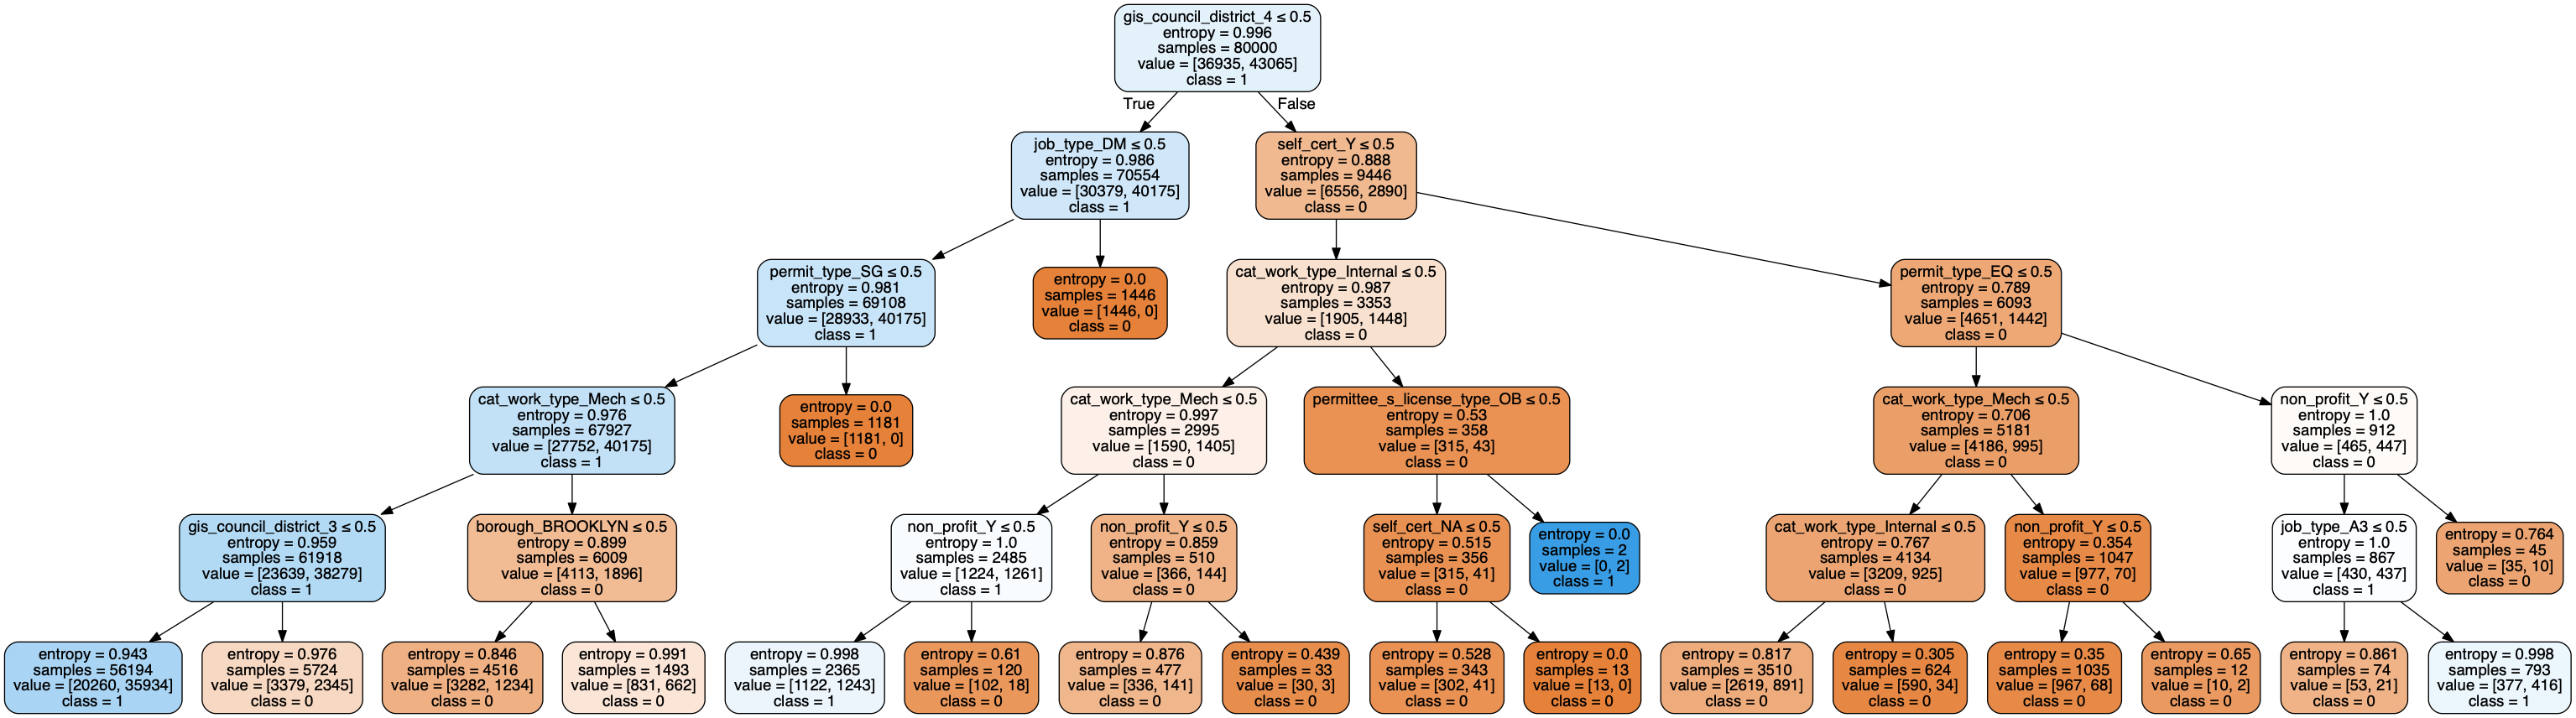

In [27]:
# Create DOT data
dot_data = export_graphviz(clf, out_file=None, 
                           feature_names=ohe_df.columns,  
                           class_names=np.unique(y).astype('str'), 
                           filled=True, 
                           rounded=True, 
                           special_characters=True)

# graph
graph = graph_from_dot_data(dot_data)

# Show graph
Image(graph.create_png())

In [28]:
X_test_ohe = ohe.transform(X_test)
y_preds = clf.predict(X_test_ohe)

print('Accuracy: ', accuracy_score(y_test, y_preds))

Accuracy:  0.65235


In [29]:
clf.feature_importances_

array([0.00027836, 0.0326078 , 0.00807872, 0.        , 0.00138698,
       0.2124982 , 0.        , 0.        , 0.        , 0.09640437,
       0.20204936, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.00073441, 0.        , 0.        , 0.        ,
       0.        , 0.01244967, 0.        , 0.        , 0.        ,
       0.        , 0.02877594, 0.        , 0.        , 0.     

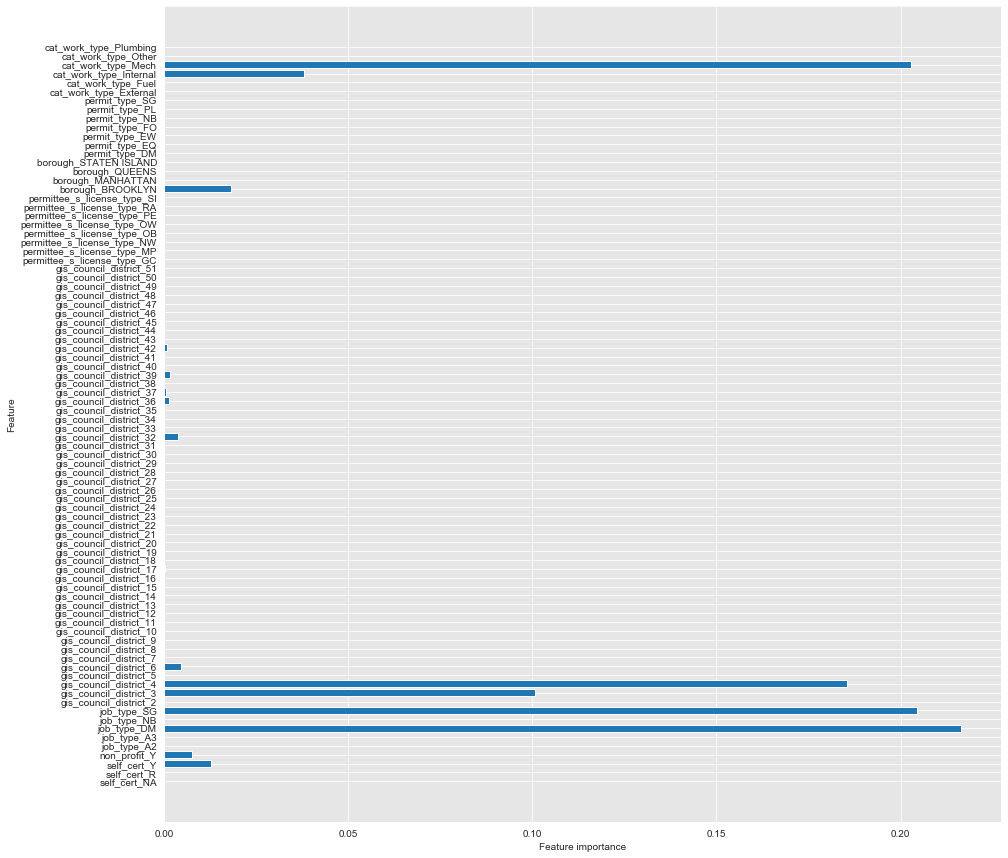

In [90]:
import matplotlib.pyplot as plt

def plot_feature_importances(model):
    
    n_features = X_train_ohe.shape[1]
    
    plt.figure(figsize=(15,15))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    
    plt.yticks(np.arange(n_features), col_names) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')

plot_feature_importances(clf)

Looks like the important features are:
- Individual Business type (DUH)
- Work type (mech, fuel, mech)
- City Council District 4 (midtown east, UES, Stytown)
- City Council District 3 (midtown west, Hudson Yards)
- Job Type - SG
- Job Type - A3
- Non Profit Yes (NYCHA?)
- Self Cert Yes (Landlords working on own buildings?)

**Confusion Matrix**

In [ ]:
#make X_test into a dataframe
#make Y_test into a dataframe

In [30]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Test set predictions
prediction = clf.predict(X_test_ohe)

# Confusion matrix and classification report
print(confusion_matrix(y_test, prediction))
print(classification_report(y_test, prediction))

dt_cm = confusion_matrix(y_test, prediction)

[[3745 5596]
 [1357 9302]]
              precision    recall  f1-score   support

           0       0.73      0.40      0.52      9341
           1       0.62      0.87      0.73     10659

    accuracy                           0.65     20000
   macro avg       0.68      0.64      0.62     20000
weighted avg       0.68      0.65      0.63     20000



Text(0.5, 1, 'Confusion Matrix')

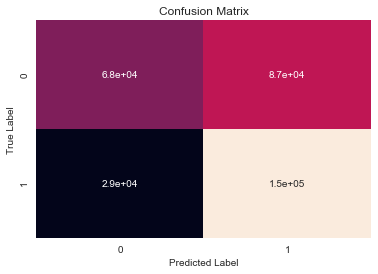

In [92]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(dt_cm,annot=True,cbar=False)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')


In [100]:
import numpy as np
from sklearn.metrics import roc_auc_score
dt_roc_auc =roc_auc_score(y_test, prediction)
dt_roc_auc

0.6412275690377067

**Random Forest**

In [31]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier

Bagging Trees:

A Bagging classifier is an ensemble meta-estimator that fits base classifiers each on random subsets of the original dataset and then aggregate their individual predictions (either by voting or by averaging) to form a final prediction. Such a meta-estimator can typically be used as a way to reduce the variance of a black-box estimator (e.g., a decision tree), by introducing randomization into its construction procedure and then making an ensemble out of it.

- n_estimators = The number of base estimators in the ensemble.

In [32]:
bagging_trees = BaggingClassifier(DecisionTreeClassifier(criterion='gini'), 
                                 n_estimators=20)

In [33]:
bagging_trees.fit(X_train_ohe, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None,
                                                        criterion='gini',
                                                        max_depth=None,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf=0.0,
                                                        presort=False,
                                                        random_state=None,
                                                        splitter='best'),
    

In [34]:
y_predict = clf.predict(X_test_ohe)
y_predict

array([1, 1, 1, ..., 0, 1, 1])

In [35]:
# Training accuracy score
bagging_trees.score(X_train_ohe, y_train)

0.7322

In [36]:
# Test accuracy score
bagging_trees.score(X_test_ohe, y_test)

0.7051

Parameter Tuning

In [38]:
from sklearn.model_selection import RandomizedSearchCV

n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

max_features = ['auto', 'sqrt']

max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

min_samples_split = [2, 5, 10]

min_samples_leaf = [1, 2, 4]

bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

print(random_grid)
{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

Fit to Random Forest

In [ ]:
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.datasets import make_regression

# # Use the random grid to search for best hyperparameters
# # First create the base model to tune
# rf = RandomForestRegressor()

# # Random search of parameters, using 3 fold cross validation, 
# # search across 100 different combinations, and use all available cores
# rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# # Fit the random search model
# rf_random.fit(X_train_ohe, y_train)

In [ ]:
# Instantiate and fit a RandomForestClassifier
random_forest = RandomForestClassifier(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
random_forest.fit(X_train_ohe, y_train)

In [ ]:
# Training accuracy score
random_forest.score(X_train_ohe, y_train)

In [ ]:
# Test accuracy score
random_forest.score(X_test_ohe, y_test)

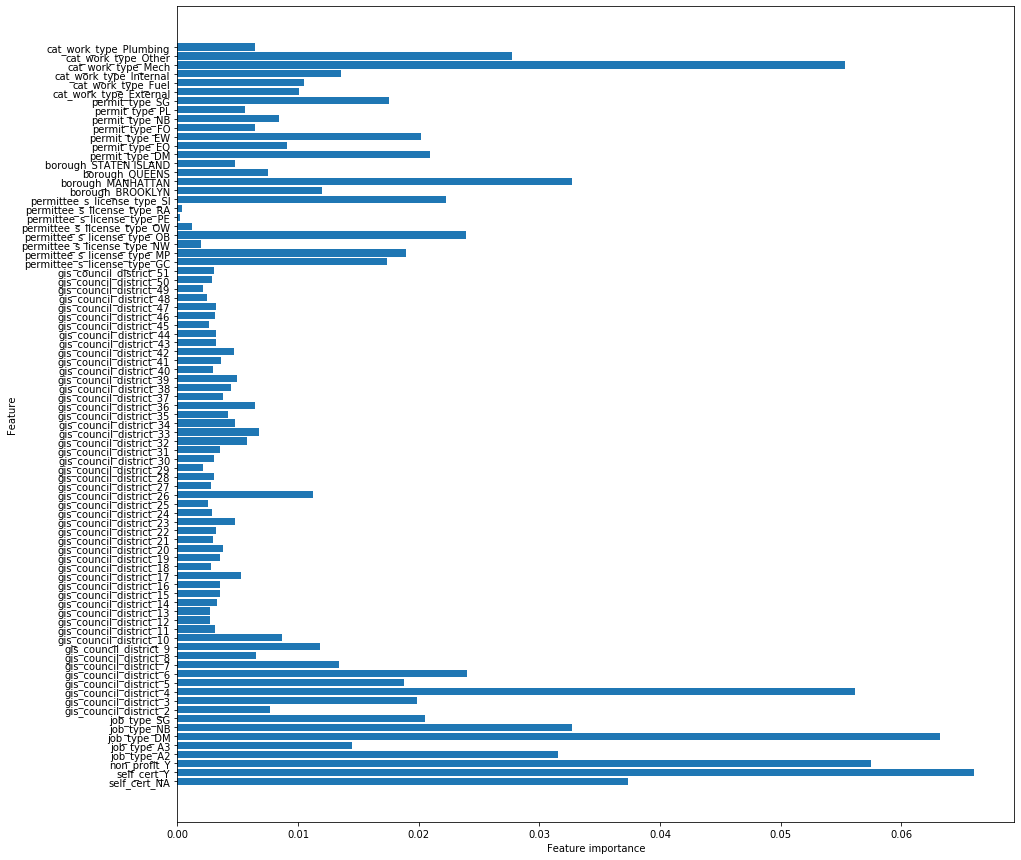

In [157]:

plot_feature_importances(random_forest)

Look at individual trees in the forest!

In [158]:
# Instantiate and fit a RandomForestClassifier
single_forest = RandomForestClassifier(n_estimators = 5, max_features= 10, max_depth= 2)
single_forest.fit(X_train_ohe, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=2, max_features=10, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=5,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [159]:
# First tree from the forest!
tree_one = single_forest.estimators_[0]

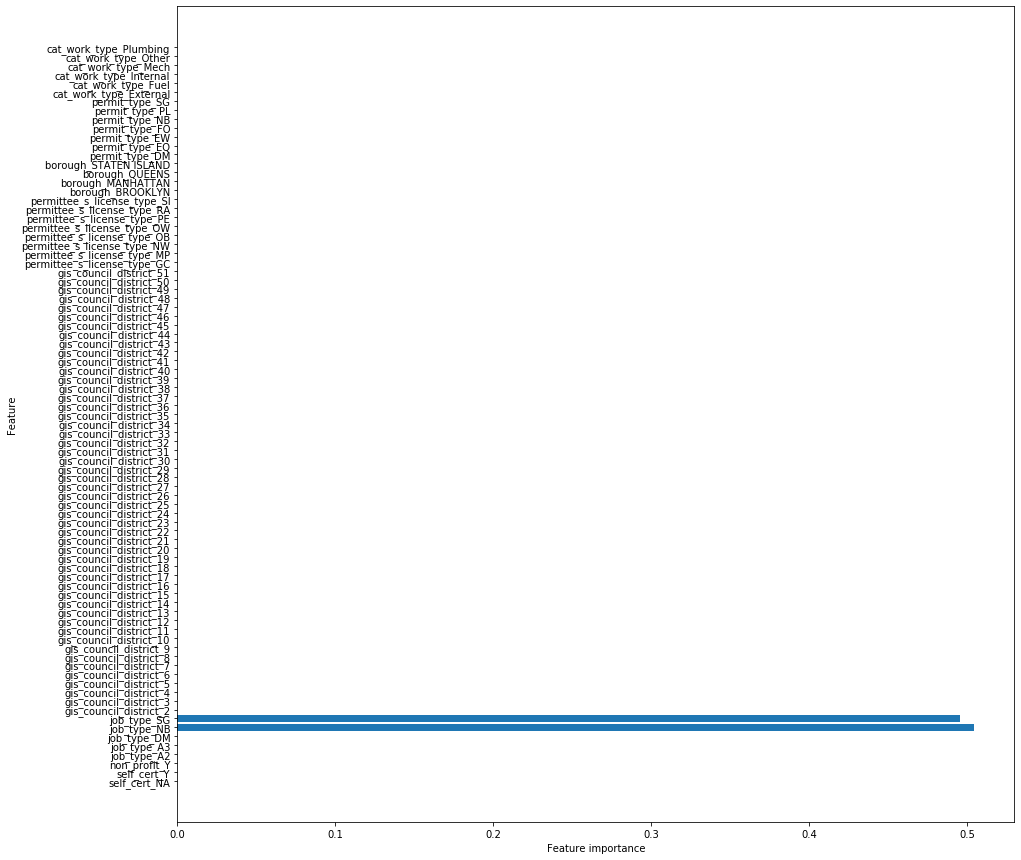

In [160]:
# Feature importance for this single tree
plot_feature_importances(tree_one)

In [163]:
# Second tree from forest
tree_two = single_forest.estimators_[1]

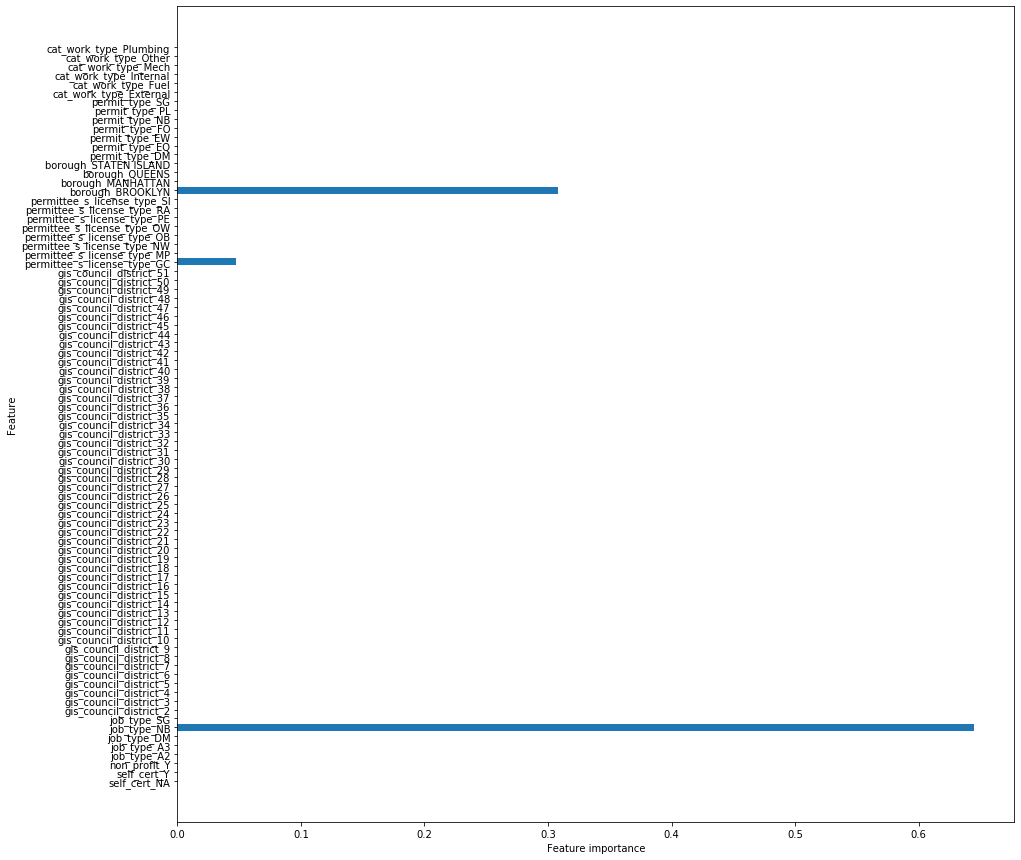

In [164]:
# Feature importance
plot_feature_importances(tree_two)

Confusion Matrix

In [49]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Test set predictions
prediction_forest = random_forest.predict(X_test_ohe)

# Confusion matrix and classification report
print(confusion_matrix(y_test, prediction_forest))
print(classification_report(y_test, prediction_forest))

cm_rf = confusion_matrix(y_test, prediction_forest)

[[ 91504  63686]
 [ 31112 149414]]
              precision    recall  f1-score   support

           0       0.75      0.59      0.66    155190
           1       0.70      0.83      0.76    180526

    accuracy                           0.72    335716
   macro avg       0.72      0.71      0.71    335716
weighted avg       0.72      0.72      0.71    335716



In [50]:
rf_fit = random_forest.fit(X_train_ohe, y_train)

In [51]:
rf_prob = rf_fit.predict_proba(X_test_ohe)

In [232]:
rf_prob

array([[0.09342723, 0.90657277],
       [0.19913177, 0.80086823],
       [0.15314957, 0.84685043],
       ...,
       [0.75095858, 0.24904142],
       [0.00272727, 0.99727273],
       [0.58684921, 0.41315079]])

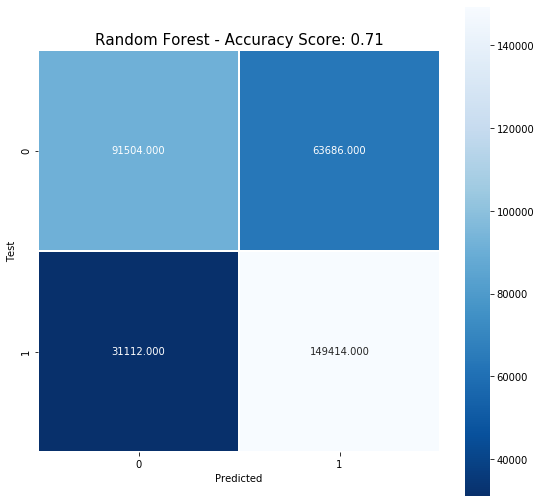

In [53]:
import seaborn as sns
import matplotlib.pyplot as plt
#confusion matrix with seaborn
plt.figure(figsize=(9,9))
sns.heatmap(cm_rf, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Test');
plt.xlabel('Predicted');
all_sample_title = 'Random Forest - Accuracy Score: 0.71'
plt.title(all_sample_title, size = 15);

In [1]:
#Auc score
rf_roc_auc =roc_auc_score(y_test, prediction_forest)
rf_roc_auc

NameError: name 'roc_auc_score' is not defined

In [54]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

test_fpr, test_tpr, test_thresholds = roc_curve(y_test, rf_prob)

print('Test AUC: {}'.format(auc(test_fpr, test_tpr)))

# Seaborn's beautiful styling
sns.set_style('darkgrid', {'axes.facecolor': '0.9'})

plt.figure(figsize=(10, 8))
lw = 2

plt.plot(test_fpr, test_tpr, color='darkorange',
         lw=lw, label='Test ROC curve')

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('(ROC) Curve - Random Forest')
plt.legend(loc='lower right')
plt.show()

ValueError: bad input shape (335716, 2)

**AdaBoost**

In [170]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

In [173]:
# Instantiate an AdaBoostClassifier
adaboost_clf = AdaBoostClassifier(random_state=40)

In [174]:
adaboost_clf.fit(X_train_ohe, y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=40)

In [175]:
X_train_ohe.shape

(80000, 83)

In [176]:
X_test_ohe.shape

(20000, 83)

In [177]:
# AdaBoost model predictions
adaboost_train_preds = adaboost_clf.predict(X_train_ohe)
adaboost_test_preds = adaboost_clf.predict(X_test_ohe)

In [178]:
print(accuracy_score(y_train, adaboost_train_preds))
print(accuracy_score(y_test, adaboost_test_preds))

0.6834
0.6805


In [179]:
#product confusion matrix for AdaBoost
print(confusion_matrix(y_test, adaboost_test_preds))
print(classification_report(y_test, adaboost_test_preds))

[[5132 4209]
 [2181 8478]]
              precision    recall  f1-score   support

          No       0.70      0.55      0.62      9341
         YES       0.67      0.80      0.73     10659

    accuracy                           0.68     20000
   macro avg       0.69      0.67      0.67     20000
weighted avg       0.68      0.68      0.67     20000



In [171]:
# Instantiate an GradientBoostingClassifier
gbt_clf = GradientBoostingClassifier(random_state=42)

In [172]:
gbt_clf.fit(X_train_ohe, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=42, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [173]:
# model predictions
gbt_train_preds = gbt_clf.predict(X_train_ohe)
gbt_test_preds = gbt_clf.predict(X_test_ohe)

In [174]:
#produce confusion matrix for gradient boosting
print(confusion_matrix(y_test, gbt_test_preds))
print(classification_report(y_test, gbt_test_preds))

cm_gbt = confusion_matrix(y_test, gbt_test_preds)


[[5009 4332]
 [1745 8914]]
              precision    recall  f1-score   support

           0       0.74      0.54      0.62      9341
           1       0.67      0.84      0.75     10659

    accuracy                           0.70     20000
   macro avg       0.71      0.69      0.68     20000
weighted avg       0.71      0.70      0.69     20000



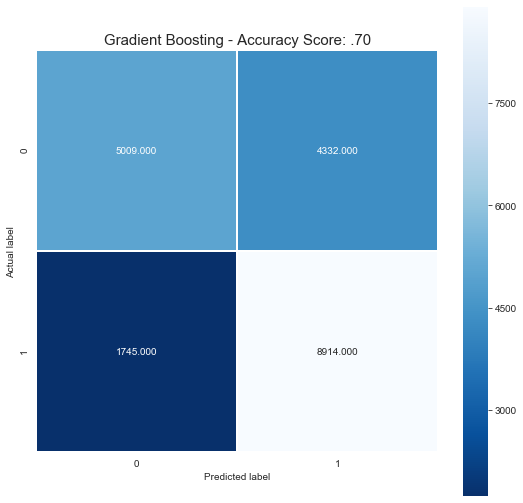

In [202]:
import seaborn as sns
import matplotlib.pyplot as plt
#confusion matrix with seaborn
plt.figure(figsize=(9,9))
sns.heatmap(cm_gbt, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Gradient Boosting - Accuracy Score: .70'.format(gbt_test_preds)
plt.title(all_sample_title, size = 15);

**Logistic Regression**

In [32]:
df['residential'].value_counts()

YES    53724
No     46276
Name: residential, dtype: int64

In [145]:
y_test.head()

114554     1
62966      1
231875     1
1045976    1
833763     1
Name: residential, dtype: int64

In [55]:
from sklearn.linear_model import LogisticRegression

logisticRegr = LogisticRegression()

logreg = LogisticRegression().fit(X_train_ohe,y_train)

lr_predictions = logreg.predict(X_test_ohe)

lr_dec = logreg.decision_function(X_test_ohe)

logreg.score(X_test_ohe, y_test)
log_score =logreg.score(X_test_ohe, y_test)

/Users/melissamunz/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [228]:
lr_dec

array([ 1.45248174,  0.97451058,  1.31847202, ..., -0.68161187,
        0.55298791,  1.47375089])

In [56]:
#produce confusion matrix for gradient boosting
print(confusion_matrix(y_test, lr_predictions))
print(classification_report(y_test, lr_predictions))
cm =confusion_matrix(y_test, lr_predictions)

[[ 92844  62346]
 [ 41855 138671]]
              precision    recall  f1-score   support

           0       0.69      0.60      0.64    155190
           1       0.69      0.77      0.73    180526

    accuracy                           0.69    335716
   macro avg       0.69      0.68      0.68    335716
weighted avg       0.69      0.69      0.69    335716



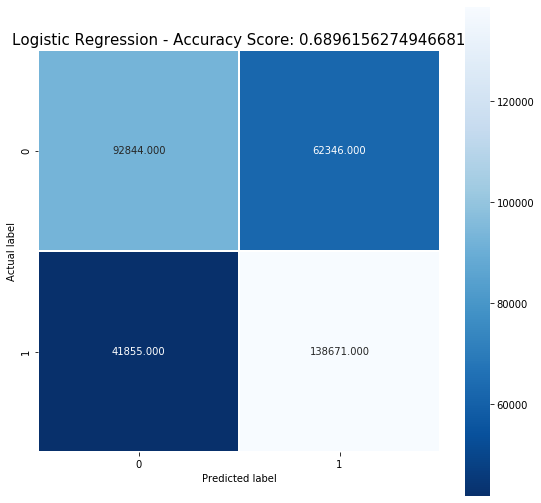

In [57]:
import seaborn as sns
import matplotlib.pyplot as plt
#confusion matrix with seaborn
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Logistic Regression - Accuracy Score: {0}'.format(log_score)
plt.title(all_sample_title, size = 15);

Test AUC: 0.7549269992641883


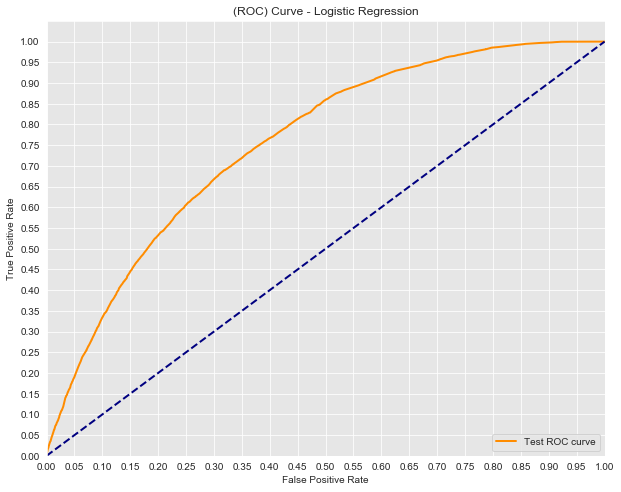

In [58]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

test_fpr, test_tpr, test_thresholds = roc_curve(y_test, lr_dec)

print('Test AUC: {}'.format(auc(test_fpr, test_tpr)))

# Seaborn's beautiful styling
sns.set_style('darkgrid', {'axes.facecolor': '0.9'})

plt.figure(figsize=(10, 8))
lw = 2

plt.plot(test_fpr, test_tpr, color='darkorange',
         lw=lw, label='Test ROC curve')

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('(ROC) Curve - Logistic Regression')
plt.legend(loc='lower right')
plt.show()

**SVM**

In [205]:
from sklearn.svm import SVC 
from sklearn.model_selection import train_test_split  
from time import time

tic = time()
svclassifier = SVC(kernel='rbf', C=1) 
#smaller C, bigger the budget. If too small C, high bias model.
#bigger C, smaller budget. High variance model.
#when svm doesnt work, try different kernals (rbf, linear, sigmoid, poly, etc)

svclassifier.fit(X_train_ohe, y_train) 
svc_y_pred = svclassifier.predict(X_test_ohe)
toc = time()
print("run time is {} seconds".format(toc-tic))


/Users/melissamunz/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


run time is 2195.881294965744 seconds


In [206]:
from sklearn.metrics import classification_report, confusion_matrix , accuracy_score
print(confusion_matrix(y_test,svc_y_pred))  
print(classification_report(y_test,svc_y_pred)) 
print("The accuracy score is" + " "+ str(accuracy_score(y_test, svc_y_pred)))

[[5504 3837]
 [2458 8201]]
              precision    recall  f1-score   support

           0       0.69      0.59      0.64      9341
           1       0.68      0.77      0.72     10659

    accuracy                           0.69     20000
   macro avg       0.69      0.68      0.68     20000
weighted avg       0.69      0.69      0.68     20000

The accuracy score is 0.68525
